In [ ]:
# default_exp models.wavenet

In [ ]:
# hide
import sys

sys.path.append("..")

# Wavenet model

> The WaveNet` architecture for time series forecasting. <https://arxiv.org/pdf/1609.03499.pdf>

Mostly copied from <https://github.com/MSRDL/Deep4Cast>

In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai.basics import *


/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Model

In [ ]:
# export

class ConcreteDropout(torch.nn.Module):
    """Applies Dropout to the input, even at prediction time and learns dropout probability
    from the data.
    
    In convolutional neural networks, we can use dropout to drop entire channels using
    the 'channel_wise' argument.
    
    Arguments:
        * dropout_regularizer (float): Should  be set to 2 / N, where N is the number of training examples.
        * init_range (tuple): Initial range for dropout probabilities.
        * channel_wise (boolean): apply dropout over all input or across convolutional channels.
    """
    def __init__(self,
                 dropout_regularizer=1e-5,
                 init_range=(0.1, 0.3),
                 channel_wise=False):
        super(ConcreteDropout, self).__init__()
        self.dropout_regularizer = dropout_regularizer
        self.init_range = init_range
        self.channel_wise = channel_wise

        # Initialize dropout probability
        init_min = np.log(init_range[0]) - np.log(1. - init_range[0])
        init_max = np.log(init_range[1]) - np.log(1. - init_range[1])
        self.p_logit = torch.nn.Parameter(
            torch.empty(1).uniform_(init_min, init_max))

    def forward(self, x):
        """Returns input but with randomly dropped out values."""
        # Get the dropout probability
        p = torch.sigmoid(self.p_logit)

        # Apply Concrete Dropout to input
        out = self._concrete_dropout(x, p)

        # Regularization term for dropout parameters
        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)

        # The size of the dropout regularization depends on the kind of input
        if self.channel_wise:
            # Dropout only applied to channel dimension
            input_dim = x.shape[1]
        else:
            # Dropout applied to all dimensions
            input_dim = np.prod(x.shape[1:])
        dropout_regularizer *= self.dropout_regularizer * input_dim

        return out, dropout_regularizer.mean()

    def _concrete_dropout(self, x, p):
        # Empirical parameters for the concrete distribution
        eps = 1e-7
        temp = 0.1

        # Apply Concrete dropout channel wise or across all input
        if self.channel_wise:
            unif_noise = torch.rand_like(x[:, :, [0]])
        else:
            unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                     - torch.log(1 - p + eps)
                     + torch.log(unif_noise + eps)
                     - torch.log(1 - unif_noise + eps))
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob

        # Need to make sure we have the right shape for the Dropout mask
        if self.channel_wise:
            random_tensor = random_tensor.repeat([1, 1, x.shape[2]])

        # Drop weights
        retain_prob = 1 - p
        x = torch.mul(x, random_tensor)
        x /= retain_prob

        return x

In [ ]:
# export
class WaveNet(torch.nn.Module):
    """Implements `WaveNet` architecture for time series forecasting. Inherits 
    from pytorch `Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`_.
    Vector forecasts are made via a fully-connected linear layer.
    References:
        - `WaveNet: A Generative Model for Raw Audio <https://arxiv.org/pdf/1609.03499.pdf>`_
    
    Arguments:
        * input_channels (int): Number of covariates in input time series.
        * output_channels (int): Number of target time series.
        * horizon (int): Number of time steps to forecast.
        * hidden_channels (int): Number of channels in convolutional hidden layers.
        * skip_channels (int): Number of channels in convolutional layers for skip connections.
        * n_layers (int): Number of layers per Wavenet block (determines receptive field size).
        * n_blocks (int): Number of Wavenet blocks.
        * dilation (int): Dilation factor for temporal convolution.
    """
    def __init__(self,
                 input_channels,
                 output_channels,
                 horizon,
                 hidden_channels=64,
                 skip_channels=64,
                 n_layers=7,
                 n_blocks=1,
                 dilation=2):
        """Inititalize variables."""
        super(WaveNet, self).__init__()
        self.output_channels = output_channels
        self.horizon = horizon
        self.hidden_channels = hidden_channels
        self.skip_channels = skip_channels
        self.n_layers = n_layers
        self.n_blocks = n_blocks
        self.dilation = dilation
        self.dilations = [dilation**i for i in range(n_layers)] * n_blocks

        # Set up first layer for input
        self.do_conv_input = ConcreteDropout(channel_wise=True)
        self.conv_input = torch.nn.Conv1d(
            in_channels=input_channels,
            out_channels=hidden_channels,
            kernel_size=1
        )

        # Set up main WaveNet layers
        self.do, self.conv, self.skip, self.resi = [], [], [], []
        for d in self.dilations:
            self.do.append(ConcreteDropout(channel_wise=True))
            self.conv.append(torch.nn.Conv1d(in_channels=hidden_channels,
                                             out_channels=hidden_channels,
                                             kernel_size=2,
                                             dilation=d))
            self.skip.append(torch.nn.Conv1d(in_channels=hidden_channels,
                                             out_channels=skip_channels,
                                             kernel_size=1))
            self.resi.append(torch.nn.Conv1d(in_channels=hidden_channels,
                                             out_channels=hidden_channels,
                                             kernel_size=1))
        self.do = torch.nn.ModuleList(self.do)
        self.conv = torch.nn.ModuleList(self.conv)
        self.skip = torch.nn.ModuleList(self.skip)
        self.resi = torch.nn.ModuleList(self.resi)

        # Set up nonlinear output layers
        self.do_conv_post = ConcreteDropout(channel_wise=True)
        self.conv_post = torch.nn.Conv1d(
            in_channels=skip_channels,
            out_channels=skip_channels,
            kernel_size=1
        )
        self.do_linear_mean = ConcreteDropout()
        self.do_linear_std = ConcreteDropout()
        self.do_linear_df = ConcreteDropout()
        self.linear_mean = torch.nn.Linear(
            skip_channels, horizon*output_channels)
        self.linear_std = torch.nn.Linear(
            skip_channels, horizon*output_channels)
        self.linear_df = torch.nn.Linear(
            skip_channels, horizon*output_channels)

    def forward(self, inputs):
        """Forward function."""
        output, reg_e = self.encode(inputs)
        output_df, reg_d = self.decode(output)

        # Regularization
        regularizer = reg_e + reg_d

        return output_df # , 'loc': output_mean, 'scale': output_std, 'regularizer': regularizer}

    def encode(self, inputs: torch.Tensor):
        """Returns embedding vectors.
        
        Arguments:
            * inputs: time series input to make forecasts for
        """
        # Input layer
        output, res_conv_input = self.do_conv_input(inputs)
        output = self.conv_input(output)

        # Loop over WaveNet layers and blocks
        regs, skip_connections = [], []
        for do, conv, skip, resi in zip(self.do, self.conv, self.skip, self.resi):
            layer_in = output
            output, reg = do(layer_in)
            output = conv(output)
            output = torch.nn.functional.relu(output)
            skip = skip(output)
            output = resi(output)
            output = output + layer_in[:, :, -output.size(2):]
            regs.append(reg)
            skip_connections.append(skip)

        # Sum up regularizer terms and skip connections
        regs = sum(r for r in regs)
        output = sum([s[:, :, -output.size(2):] for s in skip_connections])

        # Nonlinear output layers
        output, res_conv_post = self.do_conv_post(output)
        output = torch.nn.functional.relu(output)
        output = self.conv_post(output)
        output = torch.nn.functional.relu(output)
        output = output[:, :, [-1]]
        output = output.transpose(1, 2)

        # Regularization terms
        regularizer = res_conv_input \
            + regs \
            + res_conv_post

        return output, regularizer

    def decode(self, inputs: torch.Tensor):
        """Returns forecasts based on embedding vectors.
        
        Arguments:
            * inputs: embedding vectors to generate forecasts for
        """
        # Apply dense layer to match output length
        output_mean, res_linear_mean = self.do_linear_mean(inputs)
        output_std, res_linear_std = self.do_linear_std(inputs)
        output_df, res_linear_df = self.do_linear_df(inputs)
        output_mean = self.linear_mean(output_mean)
        output_std = self.linear_std(output_std).exp()
        output_df = self.linear_df(output_df).exp()

        # Reshape the layer output to match targets
        # Shape is (batch_size, output_channels, horizon)
        batch_size = inputs.shape[0]
        output_mean = output_mean.reshape(
            (batch_size, self.output_channels, self.horizon)
        )
        output_std = output_std.reshape(
            (batch_size, self.output_channels, self.horizon)
        )
        output_df = output_df.reshape(
            (batch_size, self.output_channels, self.horizon)
        )

        # Regularization terms
        regularizer = res_linear_mean + res_linear_std + res_linear_df

        return output_df, regularizer

    @property
    def n_parameters(self):
        """Returns the number of model parameters."""
        par = list(self.parameters())
        s = sum([np.prod(list(d.size())) for d in par])
        return s

    @property
    def receptive_field_size(self):
        """Returns the length of the receptive field."""
        return self.dilation * max(self.dilations)

In [ ]:

class LogTransform(Transform):
    r"""Natural logarithm of target covariate + `offset`.
    
    .. math:: y_i = log_e ( x_i + \mbox{offset} )
    Args:
        * offset (float): amount to add before taking the natural logarithm
        * targets (list): list of indices to transform.
    Example:
        >>> transforms.LogTransform(targets=[0], offset=1.0)
    """

    def __init__(self, target_dim=None, offset=0.0):
        self.offset = offset
        self.target_dim = target_dim

    def encodes(self, sample):
        X = sample[0]
        y = sample[1]

        if self.target_dim:
            X[:,self.target_dim, :] = torch.log(self.offset + X[:,self.target_dim, :])
            y[:,self.target_dim, :] = torch.log(self.offset + y[:,self.target_dim, :])
        else:
            X = torch.log(self.offset + X)
            y = torch.log(self.offset + y)
        return X,y

    def decodes(self, sample):
        X, y = sample[0], sample[1]

        if self.target_dim:
            X[:, self.target_dim, :] = torch.exp(X[:, self.target_dim, :]) - self.offset
        else:
            X = torch.exp(X) - self.offset
            y = torch.exp(y) - self.offset

        return X,y


In [ ]:
tmf = LogTransform([0], offset=1.0)
x, y = tensor([[[0.0,1.0,2.1]]]), torch.randn(1,1,3)
_x,_y = tmf((x,y))
test_eq(_x, torch.log(1.0 + tensor([[[0.0,1.0,2.1]]])))
__a,_b = tmf.decode((_x,_y))

# Learner

In [ ]:
#export
from fastai.callback.all import *

@delegates(WaveNet.__init__)
def wavelet_learner(dbunch, output_channels=None, metrics=None, hidden_channels=89, skip_channels =199, **kwargs):
    "Build a dnn style learner"
    output_channels = ifnone(output_channels,dbunch.train[0][0].shape[0])
    
    model = WaveNet(input_channels=dbunch.train[0][0].shape[0],
                    output_channels=output_channels, 
                    horizon = dbunch.train_dl.horizon,
                    hidden_channels=hidden_channels,
                    skip_channels=skip_channels,
                    **kwargs
                   )
    
    dbunch.after_batch.add(LogTransform([0], offset=1.0))
    learn = Learner(dbunch, model, loss_func=F.mse_loss, opt_func= Adam, metrics=L(metrics)+L(mae, smape),cbs=[ShowGraphCallback()])
    
    return learn

In [ ]:
from fastseq.all import *
from fastseq.core import *
from fastai.basics import *

In [ ]:
# hide
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = 14, lookback = 128, bs=16, nrows=100, device='cpu')

test_eq(data.train_dl.one_batch()[0].is_cuda,False)
for o in data.valid_dl:
    print(o[0].shape)

torch.Size([24, 1, 128])
torch.Size([24, 1, 128])
torch.Size([24, 1, 128])
torch.Size([24, 1, 128])
torch.Size([4, 1, 128])


In [ ]:
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = 14, lookback = 128, bs=64, nrows=1000, device = 'cpu')

In [ ]:
learn = wavelet_learner(data)

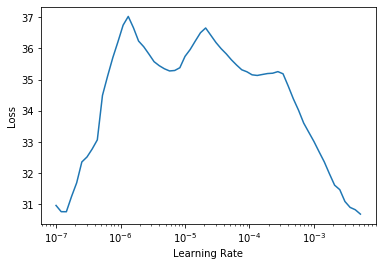

In [ ]:
from fastai.callback.all import *
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,mae,smape,time
0,28.526920,inf,inf,nan,00:08


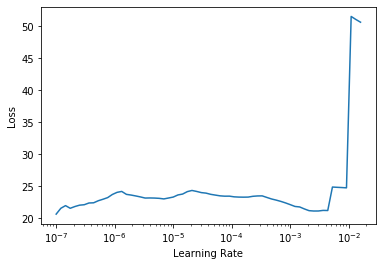

In [ ]:
from fastai.callback.all import *
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,mae,smape,time
0,19.681347,inf,inf,nan,00:08
1,14.960419,inf,inf,nan,00:08
2,12.363111,inf,inf,nan,00:08


In [ ]:
learn.validate()

(#3) [inf,inf,nan]

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
